In [1]:
import sys
# This on is a path correcting code, which is used to find the path of QuSim.
sys.path.append('../../..')
import QuSim.DataPlot.plot_lib as pl
import QuSim.Instruments.tools as tools
import QuSim.Instruments.stochastic_gen as sg
import QuSim.System.transmon_system as qs
import QuSim.Instruments.angle as  ang
from QuSim.Instruments.angle import get_angle

import numpy as np
import json
import matplotlib.pyplot as plt

from tqdm import *
from time import *
from sympy import*
import copy
import pickle
from qutip import*

import argparse

def var_name2str(variable):
    def nested_var_name2str(value):
        if isinstance(value, list):
            return [nested_var_name2str(item) for item in value]
        else:
            for name in globals():
                if eval(name) == value:
                    return name
            return str(value)
    return nested_var_name2str(variable)

In [100]:
N = None # Maximum excitation level
w = [4] # Qubit frequency
q_dim = [2 for _ in range(len(w))]
alpha =[-0.3] # Anharmonicity

_system = qs.qubit_system(N, q_dim, w, alpha)

state_0, E_0, index_0 = _system.get_eigenstates_energy((0,))
state_1, E_1, index_1 = _system.get_eigenstates_energy((1,))

init_state_dic ={
    "0": state_0,
    "1": state_1,
}

args = {
    "rt": 1,
    "tau_list": [0,1,200],
    "noise": 0.22e-3,
    "type": "Z",
    "inistate": "1"
}

repeat_time = args["rt"]
tau_list = np.linspace(*args["tau_list"])
half_pi_gt = 10; bisa_amp = 1/(2*half_pi_gt)
noise_var = args["noise"]
ramsy_pop = []
noise_type = args["type"]
init_state = init_state_dic[args["inistate"]]
if noise_type == "Z":
    q_indeces = 1
else:
    q_indeces = [0,1]

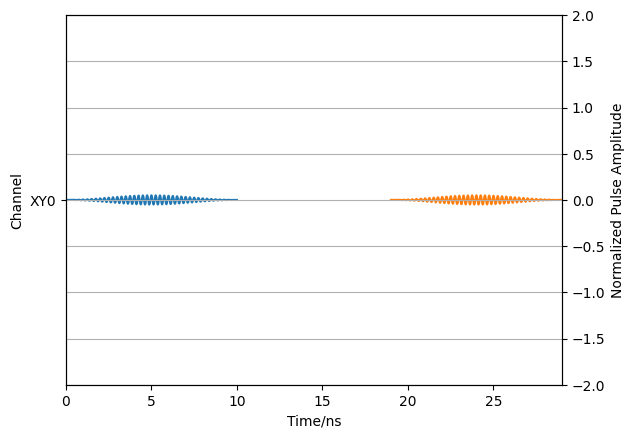

0

In [101]:
tau_d = 9
total_t = tau_d + 2*half_pi_gt
simulation_option = {
    "simulation_time": total_t, # ns
    "simulation_step": 10000,
    "initial_state": [state_0, state_1] # Do multiple simulation
} 
pulse_sequence = [
    {
        'pulse_index': 0, # [m,n] represents $\Omega_{mn}$
        'type': "XY",
        'pulse_shape': "cosine",
        't_delay': 0, # unit in ns
        't_width': half_pi_gt, # unit in ns
        't_plateau':0, # unit in ns
        'freq': E_1 - E_0, # unit in GHz; Z pulse does not use it
        'phase': 0, # unit in rad; Z pulse does not use it
        'amplitude': bisa_amp,#-3.5e-3, # bisa_amp, # XY: Rabi freq; Z: biased frequency
        'q_index': 0
    },
    {
        'pulse_index': 0, # [m,n] represents $\Omega_{mn}$
        'type': "XY",
        'pulse_shape': "cosine",
        't_delay': half_pi_gt+tau_d, # unit in ns
        't_width': half_pi_gt, # unit in ns
        't_plateau':0, # unit in ns
        'freq': E_1 - E_0, # unit in GHz; Z pulse does not use it
        'phase': 0, # unit in rad; Z pulse does not use it
        'amplitude': 1*bisa_amp,#-3.5e-3, # bisa_amp, # XY: Rabi freq; Z: biased frequency
        'q_index': 0
    }
]
pl.plot_pulse_sequence(pulse_sequence, simulation_option)

In [102]:
result_list, _ = _system.system_dynamics_mesolve(simulation_option, pulse_sequence)

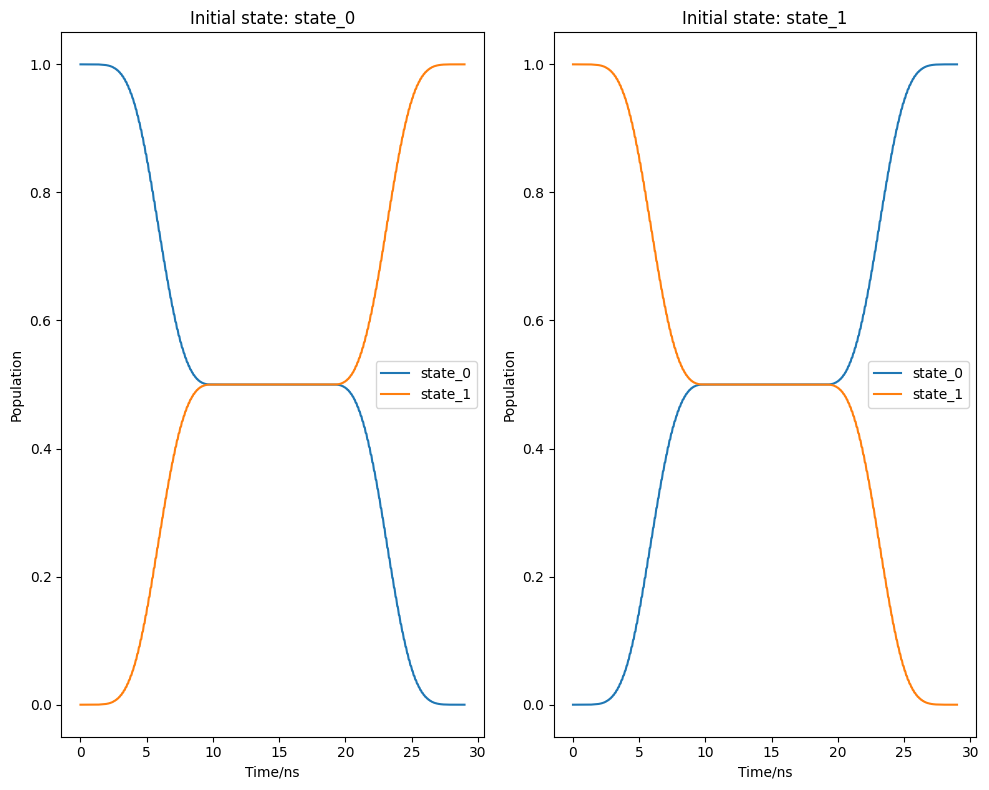

0

In [103]:
# state that you want to plot each simulation
interested_state = [
                    [state_0, state_1],
                    [state_0, state_1],
                    ]
# Convert the variable name to string in order to make legend in the plot
interested_state_label = var_name2str(interested_state)
initial_state_label = var_name2str(simulation_option["initial_state"])
%matplotlib inline
# plot state population evolution
pl.plot_population_evolution(_system, result_list, simulation_option, interested_state, interested_state_label, initial_state_label)

In [104]:
ramsy_pop = []
for tau_d in tqdm(tau_list):
    total_t = tau_d + 2*half_pi_gt
    simulation_option = {
        "simulation_time": total_t, # ns
        "simulation_step": 10000,
        "initial_state": [init_state] # Do multiple simulation
    } 
    initial01_track01 = np.zeros(shape=(repeat_time,), dtype=np.float32)
    for tt in range(repeat_time):

        pulse_sequence = [
            {
                'pulse_index': 0, # [m,n] represents $\Omega_{mn}$
                'type': "XY",
                'pulse_shape': "cosine",
                't_delay': 0, # unit in ns
                't_width': half_pi_gt, # unit in ns
                't_plateau':0, # unit in ns
                'freq': E_1 - E_0, # unit in GHz; Z pulse does not use it
                'phase': 0, # unit in rad; Z pulse does not use it
                'amplitude': 0*bisa_amp,#-3.5e-3, # bisa_amp, # XY: Rabi freq; Z: biased frequency
                'q_index': 0
            },
            {
                'pulse_index': 0, # [m,n] represents $\Omega_{mn}$
                'type': "XY",
                'pulse_shape': "cosine",
                't_delay': half_pi_gt+tau_d, # unit in ns
                't_width': half_pi_gt, # unit in ns
                't_plateau':0, # unit in ns
                'freq': E_1 - E_0, # unit in GHz; Z pulse does not use it
                'phase': 0, # unit in rad; Z pulse does not use it
                'amplitude': bisa_amp,#-3.5e-3, # bisa_amp, # XY: Rabi freq; Z: biased frequency
                'q_index': 0
            }
        ]

        result_list, _ = _system.system_dynamics_mesolve(simulation_option, pulse_sequence)
        initial01_track01[tt] = np.abs( (init_state.dag() * result_list[0].states[-1]).data[0,0] )
        # initial01_track01.append(expect(result_list[0].states[-1], ket2dm(state_ud)))
    avg_pop = np.average(initial01_track01)
    ramsy_pop.append(avg_pop)
data = [ramsy_pop, tau_list, 1, 1, [half_pi_gt, repeat_time]]

100%|██████████| 200/200 [01:31<00:00,  2.19it/s]


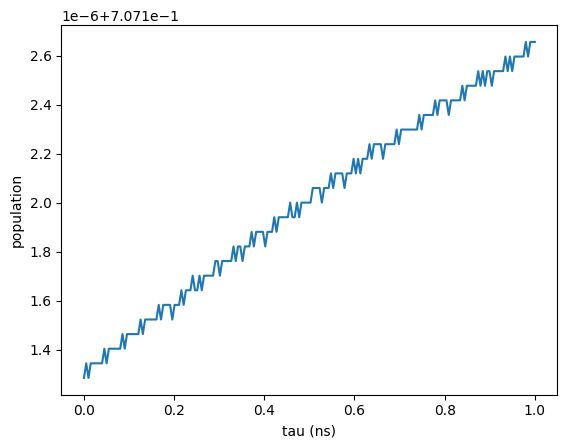

In [105]:
plt.plot(tau_list, ramsy_pop)
plt.xlabel("tau (ns)")
plt.ylabel("population")
plt.show()